T OK
QVAPOR OK


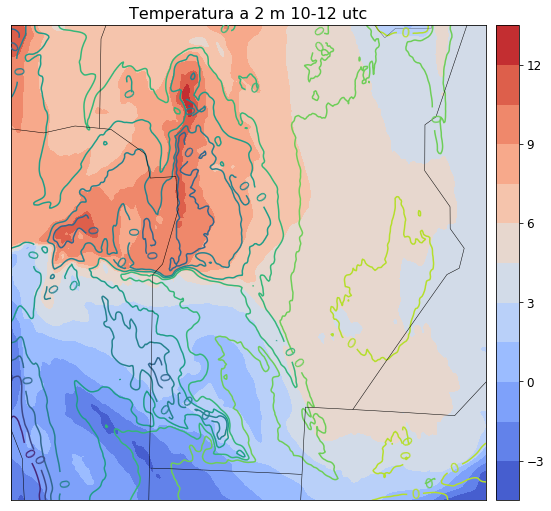

In [39]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

import cartopy.crs as crs
import cartopy._crs as _ccrs

from matplotlib.cm import get_cmap
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy,get_basemap, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import wrf



def mapa_somb_cont2(path = '../../../../media/agustin/Linux/salidas_wrf/test01/',
                   archivo = 'wrfout_d02_2018-11-10_12:00:00',
                   var_s = 0,  ts = 0,   lev_s = 0  , us = 0 , cmap = 'coolwarm', 
                   var_c1 = 0, tc1 = -1, lev_c1 = -1, uc1 = 0, cmap_c1 = 0,
                   var_c2 = 0, tc2 = -1, lev_c2 = -1, uc2 = 0, cmap_2 = 0,
                   titulo = 'Sin titulo definido', guardar = False):
    
    """CARGA DE DATOS"""
    data = Dataset(path+archivo,'r')

    lat = getvar(data,'XLAT')
    lon = getvar(data,'XLONG')
    time = getvar(data,'Times')
    znw = getvar(data,'ZNW', timeidx=wrf.ALL_TIMES)
    
    if tc1 == -1: tc1 = ts
    if tc2 == -1: tc2 = ts
    if lev_c1 == -1: lev_c1 = lev_s
    if lev_c2 == -1: lev_c2 = lev_s
    
    ks,kc1,kc2 = 1, 1, 1
    
    l=ts%24
    d=int(ts/24)+12   
    
    if var_s != 0:
        if (type (var_s)== str) and (type(tc1) == int):
            print(var_s + ' OK')
            if var_s == 'QVAPOR': ks = 1000
            var_s = getvar(data,var_s, timeidx = ts)#, units = us)# if type(us)==str else None)
            somb = True         
        else:
            print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                  Si no escribis tc2 por default es 0 \033[0m""")
            return 0
    else: somb = False
    if var_c1 != 0:
        if (type(var_c1) == str) and (type(tc1) == int):
            print(var_c1 +' OK')
            if var_c1 == 'QVAPOR': kc1 = 1000
            var_c1 = getvar(data,var_c1,timeidx= tc1)#, units = uc1 if type(uc1)==str else None)
            cont1 = True    
        else: 
            print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                  Si no escribis tc2 por default es 0 \033[0m""")
            return 0
    else: cont1 = False
        
    if var_c2 != 0:
        if (type(var_c2)== str) and (type(tc1) == int):
            print(var_c2 + ' OK')
            if var_c2 == 'QVAPOR': kc2 = 1000
            var_c2 = getvar(data,var_c2,timeidx=tc2)#, units = uc2 if type(uc2)==str else None)
            cont2 = True    
        else: 
            print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                  Si no escribis tc2 por default es 0 \033[0m""")
            return 0
    else: cont2 = False
        
                              
    if somb == True:
            if len (var_s.shape)>2: var_s = var_s[lev_s,...]
            smooth_var_s = smooth2d(var_s, 3, cenweight=4)
            lats, lons = latlon_coords(var_s)

            bm = get_basemap(var_s)

    if cont1 == True:
            if len (var_c1.shape)>2: var_c1 = var_c1[lev_c1,...]
            smooth_var_c1 = smooth2d(var_c1, 3, cenweight=4)
            lats, lons = latlon_coords(var_c1)

            bm = get_basemap(var_c1)

    if cont2 == True:
            if len (var_c2.shape)>2: var_c2 = var_c2[lev_c2,...]
            smooth_var_c2 = smooth2d(var_c2, 3, cenweight=4)

    #####################################
            
    """""""""ACA EMPIEZA EL MAPA"""""""""

    fig, ax = plt.subplots(1,figsize = (10,7))
    
    x, y = bm(to_np(lons), to_np(lats))

    if somb == True:
        ps = ax.contourf(x, y, to_np(smooth_var_s),15 , cmap = plt.get_cmap(cmap))
        cbar = bm.colorbar(ps, location = 'right', shrink=1) 
        cbar.ax.tick_params(labelsize=12)
        
    if cont1 == True:
        c1_min, c1_max, ncont =np.min(var_c1),np.max(var_c1), 10
        clev=np.linspace(c1_min,c1_max,ncont)
        pc1 = bm.contour(x,y, to_np(smooth_var_c1),clev)
        
        clab = plt.clabel(pc1,clev,fontsize=14,fmt='%.00f')

        
    if cont2 == True:
        pc2 = ax.contour(x,y, to_np(smooth_var_c2)) 
        
    minlat = np.round(np.min(lat))
    minlon = np.round(np.min(lon))
    maxlat = np.round(np.max(lat))
    maxlon = np.round(np.max(lon))

    lozada = [-31.651943,-64.07947]
    
    
    bm.drawcoastlines(linewidth=0.25)
    bm.drawstates(linewidth=0.5)
    bm.drawcountries(linewidth=0.25)
    


    plt.tight_layout()
    
    plt.title(titulo+" %s-%s utc" %(l,d), fontsize = 16)

    
    if guardar==True:
        plt.savefig("img/"+titulo+" %s-%s utc.png" 
                    %(l,d),format='png')
        
    plt.show()
    
    data.close()
    
        
mapa_somb_cont2(var_s = 'T',var_c1='QVAPOR', us = 'K',
                ts = 10,tc1 = 10, titulo='Temperatura a 2 m',
               cmap = 'coolwarm',cmap_c1='viridis')
               


### Los datos de WRF estan el el disco externo

In [41]:
data.variables.keys()

odict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'SHDMAX', 'SHDMIN', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'COSZEN', 'LAI', 'DTAUX3D', 'DTAUY3D', 'DUSFCG', 'DVSFCG', 'VAR', 'CON', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY', 'F', 'E', 'SINALPHA', 'C

In [1]:
def somb_cont (variable, titulo,cmap = 'viridis',  lev =0 , tiempo = 0, dl=2.):


    if len(variable.shape) == 4:
        var = variable[tiempo, lev,:,:]

    elif len(variable.shape) == 3:
        var = variable[tiempo,:,:]

    smooth_var = smooth2d(var, 3, cenweight=4)

    lats, lons = latlon_coords(var)

    bm = get_basemap(var)

    
    fig = plt.figure(figsize=(6,6))

    ax = plt.subplots(1)
    

    x, y = bm(to_np(lons), to_np(lats))

    plt.contourf(x, y, to_np(smooth_var),15 , cmap=get_cmap(cmap))

    [ptlat,ptlon] = [-31.651739700-dl/2.,-64.097784300-dl/2.]

    bm.plot([ptlon,ptlon],[ptlat,ptlat+dl],'-k',linewidth=2)
    bm.plot([ptlon,ptlon+dl],[ptlat+dl,ptlat+dl],'-k',linewidth=2)
    bm.plot([ptlon+dl,ptlon+dl],[ptlat+dl,ptlat],'-k',linewidth=2)
    bm.plot([ptlon+dl,ptlon],[ptlat,ptlat],'-k',linewidth=2)
    
    
    bm.drawcoastlines(linewidth=0.25)
    bm.drawstates(linewidth=0.25)
    bm.drawcountries(linewidth=0.25)
    
    plt.colorbar(shrink=.7)

    plt.title(titulo)

    plt.tight_layout()
    
    plt.show()

somb_cont(variable= t ,tiempo = 0, cmap = 'coolwarm', titulo = 'Temperatura')

NameError: name 't' is not defined

In [7]:
x,y = m(255,146)
x_,y_ = m(lat,lon)
#plt.subplot2grid((1,2),(0,0))
m.imshow(t[0,10,:,:],cmap=plt.get_cmap('coolwarm'))
m.scatter(146,255)#,s=1000)

#plt.scatter(x,y,marker='o',s=100,color='r')
m.drawparallels(np.arange(minlat,maxlat,5),labels = [0.5,0,0,0], fontsize = 10, linewidth = 0.4)
m.drawmeridians(np.arange(minlon,maxlon,10),labels=[0,0,0,0.3],fontsize = 10, linewidth = 0.4)
m.drawcoastlines(linewidth = 0.6)
m.drawcountries(linewidth = 0.5)
m.drawstates(linewidth = 0.4)
lon_ = lon[0,146]
lat_ = lat[255,0]
x,y = m(lon_, lat_)
loz = m.plot(x, y, 'bo', markersize=24)
#plt.plot(146,255,marker='o',color='r')

plt.show()

NameError: name 'm' is not defined

IndexError: too many indices

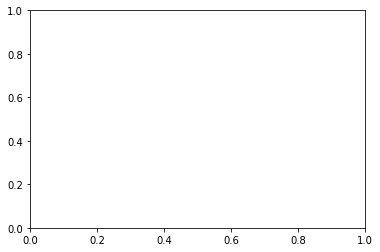

In [120]:
fig ,ax= plt.subplots(1)

dl=2.
[ptlat,ptlon] = [-31.651739700-dl/2.,-64.097784300-dl/2.]
plt.contourf(lon[0,:,:],lat[0,:,:],t[0,0,:,:])
plt.plot([ptlon,ptlon],[ptlat,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon,ptlon+dl],[ptlat+dl,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon+dl],[ptlat+dl,ptlat],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon],[ptlat,ptlat],'-k',linewidth=2)
#a= mpach.Rectangle((210,116),40,30,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(a)

plt.show()